In [1]:
import torch
import normflows as nf
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader as dl
from torch.utils.data import TensorDataset as ds
from tqdm import tqdm

In [2]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [3]:
target = nf.distributions.RingMixture()
base = nf.distributions.DiagGaussian(2)

In [4]:
def data_loader_generator(number_of_samples,batchsize):
    data_points = target.sample(number_of_samples)
    target_data_set = ds(data_points)
    target_data_loader = dl(target_data_set,batch_size=batchsize,shuffle=True)
    return target_data_loader


In [5]:
def flow_init():
    number_of_layers = 128
    flows =[]
    for i in range(number_of_layers):
        parameters = nf.nets.MLP([1,128,64,16,2],init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map=parameters))
        flows.append(nf.flows.Permute(2,mode="swap"))
    model = nf.NormalizingFlow(q0=base,flows=flows)

    return model

Has been working with a learning rate of 0.0001

In [6]:
# model = flow_init()
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(),lr =0.0005,weight_decay=0.000001)
# number_epochs = 10

In [7]:
def train_model(model, target_data_loader, number_epochs):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001) #was 0.0005, try 0.001
    tolerance = 0.00001
    previous_loss = float('inf')  # Initialize with a large value
    early_stop = False
    
    for epoch in range(number_epochs):
        if not early_stop:
            model.train()
            for data in target_data_loader:
                optimizer.zero_grad()
                
                data = data[0].to(device)  # Extract data from TensorDataset and move to device
                loss = model.forward_kld(data)
                
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                
                current_loss = loss.item()
                
                if epoch > 0:
                    loss_diff = abs(current_loss - previous_loss)
                    if loss_diff < tolerance:
                        early_stop = True
                        print(f"Early stopping at epoch {epoch+1} with loss difference {loss_diff:.6f}")
                        break
                
                previous_loss = current_loss
    
    return model

In [8]:
Models = []
sample_numbers = []

for numb in tqdm(range(1,7)):
    simple_models = flow_init().to(device=device)
    number_of_samples = 10**numb
    batch_size = 1000
    Models.append(train_model(model=simple_models,target_data_loader=data_loader_generator(number_of_samples=number_of_samples,batchsize=batch_size),number_epochs=200))
    sample_numbers.append(number_of_samples)

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [12:21<03:33, 213.76s/it]

Early stopping at epoch 25 with loss difference 0.000006


In [ ]:
print(len(Models))
print(len(sample_numbers))

6
6


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


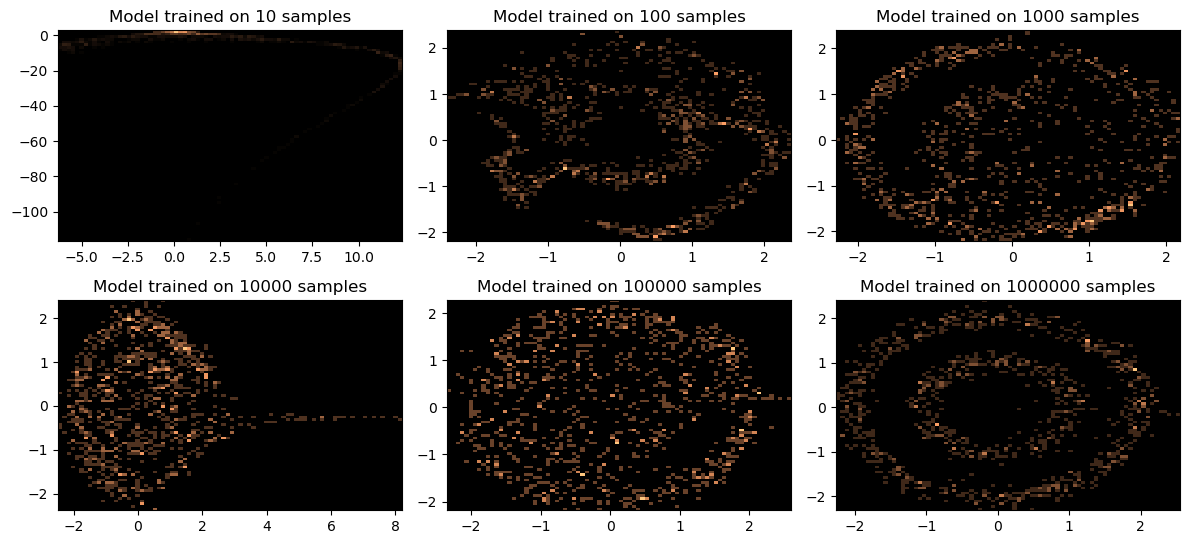

In [ ]:
#checking if the models are different
plt.figure(figsize=(12,8))
with torch.no_grad():
        for i in range(len(Models)):
                k=i+1
                validation_samples = base.sample(1000).to(device)
                guesses = torch.Tensor.cpu(Models[i](validation_samples))
                plt.subplot(3,3,k)
                plt.hist2d(guesses[:,0],guesses[:,1],bins=80,cmap="copper")
                plt.title(f'Model trained on {sample_numbers[i]} samples')
                
plt.tight_layout()
plt.show()


In [ ]:
KL_for_different_models=[]

x = target.sample(10000).detach().to(device)        
log_prob_target = target.log_prob(x)

with torch.no_grad():
        for i in range(len(Models)):
                        KL_for_current_sample_size = []
                        log_prob_model = Models[i].log_prob(x)
                        KL_target_model = (log_prob_target - log_prob_model).mean()

                        KL_for_different_models.append(KL_target_model.item())

In [ ]:
print(KL_for_different_models)

[3.813952922821045, nan, nan, 2.3393523693084717, 2.2094886302948, 1.8227224349975586]


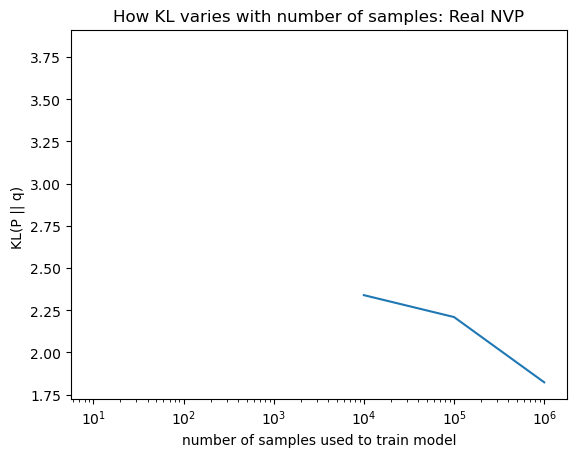

In [ ]:
#plotting to see how KL Divergence values differes with number of samples
plt.plot(sample_numbers,KL_for_different_models)
plt.xlabel('number of samples used to train model')
plt.ylabel('KL(P || q) ')
plt.xscale('log')
plt.title('How KL varies with number of samples: Real NVP')
plt.show()

In [ ]:
# for model in tqdm(Models):
#     torch.save(model.state_dict(),"polynomial.pth")